In [3]:
import pandas as pd
import nltk
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

/var/folders/4l/ns658b_x7jq0xzx004lrrl_w0000gn/T/ipykernel_11790/905033856.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### Entendimiento y Análisis de Calidad

                                         Textos_espanol  sdg
1530  El caso de los ATP y los supervisores es inusu...    4
3627  Los itinerarios de educación vocacional de alt...    4
3947  En Moldavia, las mujeres informan que tienen m...    5
1471  Al final de la escolarización obligatoria, los...    4
2684  Estas medidas excluyen a las madres de la toma...    5
2354  En las regiones en desarrollo, una proporción ...    5
114   Un accidente cerebrovascular ocurre cuando se ...    3
276   Los paÃses donde la tasa de inmunizaciÃ³n cont...    3
2086  Las encuestas de hogares muestran que las muje...    5
515   El programa tiene la responsabilidad de coordi...    3
Total de filas duplicadas: 0

Valores faltantes por columna:
Textos_espanol    0
sdg               0
dtype: int64

Total de valores faltantes en el dataset: 0


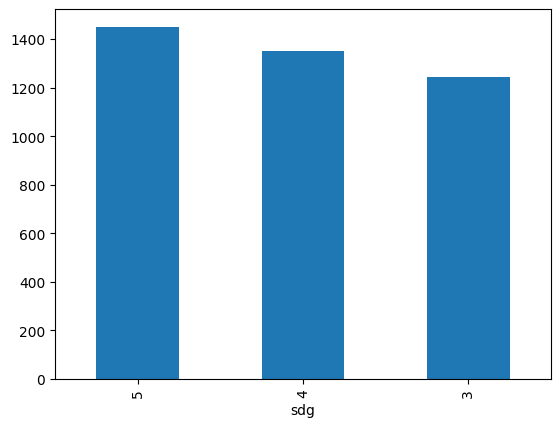

In [4]:
# Cargar los datos
df = pd.read_excel('data.xlsx')

# Mostrar una muestra de los datos
sample = df.sample(10)
print(sample)

#Explorar que las etiquetas sean congruentes con la información del negocio
df['sdg'].value_counts().plot(kind='bar')

# Verificar valores duplicados
duplicados = df.duplicated()
print(f"Total de filas duplicadas: {duplicados.sum()}")

# Mostrar las filas duplicadas (si las hay)
if duplicados.sum() > 0:
    print("Filas duplicadas:")
    print(df[duplicados])

# Verificar valores faltantes (NaN)
valores_faltantes = df.isnull().sum()
print("\nValores faltantes por columna:")
print(valores_faltantes)

# Verificar si hay alguna fila con valores faltantes
total_nan = df.isnull().sum().sum()
print(f"\nTotal de valores faltantes en el dataset: {total_nan}")

# Mostrar las filas que contienen valores faltantes (si las hay)
if total_nan > 0:
    print("\nFilas con valores faltantes:")
    print(df[df.isnull().any(axis=1)])


En la muestra de datos proporcionada, los comentarios están clasificados de acuerdo con tres categorías asociadas a los ODS 3, 4 y 5, lo que refleja un esfuerzo por relacionar las opiniones ciudadanas con estos objetivos. En cuanto a la completitud, los datos parecen estar completos, ya que no se observan valores faltantes en los comentarios ni en sus respectivas clasificaciones. En cuanto a la unicidad, es importante verificar si los comentarios están duplicados, lo cual podría afectar el análisis y la interpretación de los resultados; este aspecto no se encuentran valores duplicados en la base de  datos. En términos de consistencia, las etiquetas asociadas a los ODS parecen congruentes con el contenido de los comentarios, ya que los temas tratados se alinean con los objetivos correspondientes (por ejemplo, educación en el ODS 4 y equidad de género en el ODS 5). Por último, la validez de los datos parece adecuada, dado que las clasificaciones son coherentes con las categorías esperadas del negocio. Al observar la distribución de los datos en un histograma, se evidencia que la clasificación de los comentarios está bien balanceada entre las categorías, lo cual es positivo para los modelos de clasificación que se propongan.

In [16]:
# Definir características y etiquetas
X = df['Textos_espanol']
y = df['sdg']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test))

3239 810


### Preprocesamiento y Limpieza

En el preprocesamiento de los datos textuales se implementaron varias estrategias clave para mejorar la calidad y relevancia del texto antes de aplicar modelos de clasificación. En primer lugar, se utilizó la lematización, que consiste en reducir las palabras a su forma base o raíz (como convertir "corriendo" a "correr"). Esto permite una mayor coherencia en el análisis, ya que diferentes formas de una palabra se tratan como una sola, lo que reduce la variabilidad innecesaria. También se llevó a cabo la eliminación de stopwords, es decir, palabras muy comunes en el lenguaje (como "el", "de", "y") que no aportan información valiosa para la clasificación, lo cual simplifica el texto sin perder significado. Además, se eliminaron caracteres numéricos y signos de puntuación, ya que no contribuyen al análisis semántico de los comentarios y pueden generar ruido en el proceso de modelado. Estas estrategias aseguran que el texto preprocesado esté centrado en las palabras que realmente aportan información relevante, facilitando un análisis más efectivo y preciso en las siguientes etapas del proyecto.

In [17]:
nltk.download('stopwords')

# Cargar el modelo lemmatizador en español
nlp = spacy.load('es_core_news_sm')

# Obtener stopwords en español
spanish_stopwords = set(stopwords.words('spanish'))  # Convertir a set para mayor eficiencia en la búsqueda

# Definir un tokenizador que lematiza y elimina stopwords
def lemmatize_and_remove_stopwords(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc if token.is_alpha]  # Lemmatizar y eliminar tokens numéricos y de puntuación
    tokens_without_stopwords = [token for token in lemmatized_tokens if token not in spanish_stopwords]  # Eliminar stopwords
    return ' '.join(tokens_without_stopwords)  # Unir los tokens en un solo string


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sebastiangaona/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# Definir los pipelines de cada algoritmo para clasificación de texto
pipeMNB = Pipeline([
    ('tfi', TfidfVectorizer(tokenizer=lemmatize_and_remove_stopwords, ngram_range=(1, 3))),
    ('clf', MultinomialNB()),
])

pipeCNB = Pipeline([
    ('tfi', TfidfVectorizer(tokenizer=lemmatize_and_remove_stopwords, ngram_range=(1, 3))),
    ('clf', ComplementNB()),
])

pipeSVC = Pipeline([
    ('tfi', TfidfVectorizer(tokenizer=lemmatize_and_remove_stopwords, ngram_range=(1, 3))),
    ('clf', LinearSVC()),
])

pipeRF = Pipeline([
    ('tfi', TfidfVectorizer(tokenizer=lemmatize_and_remove_stopwords, ngram_range=(1, 3))),
    ('clf', RandomForestClassifier(n_estimators=100)),  
])

pipeGB = Pipeline([
    ('tfi', TfidfVectorizer(tokenizer=lemmatize_and_remove_stopwords, ngram_range=(1, 3))),
    ('clf', GradientBoostingClassifier(n_estimators=100)),  
])

pipeLR = Pipeline([
    ('tfi', TfidfVectorizer(tokenizer=lemmatize_and_remove_stopwords, ngram_range=(1, 3))),
    ('clf', LogisticRegression(max_iter=1000)),  
])

In [19]:
# Entrenar los modelos con el conjunto de entrenamiento
pipeMNB.fit(X_train, y_train)
pipeCNB.fit(X_train, y_train)
pipeSVC.fit(X_train, y_train)
pipeRF.fit(X_train, y_train)
pipeGB.fit(X_train, y_train)
pipeLR.fit(X_train, y_train)

# Predecir y evaluar los modelos con el conjunto de prueba
predictMNB = pipeMNB.predict(X_test)
predictCNB = pipeCNB.predict(X_test)
predictSVC = pipeSVC.predict(X_test)
predictRF = pipeRF.predict(X_test)
predictGB = pipeGB.predict(X_test)
predictLR = pipeLR.predict(X_test)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/

In [20]:
print("MNB")
print(classification_report(y_test, predictMNB))

print("CNB")
print(classification_report(y_test, predictCNB))

print("SVC")
print(classification_report(y_test, predictSVC))

print("RF")
print(classification_report(y_test, predictRF))

print("GB")
print(classification_report(y_test, predictGB))

print("LR")
print(classification_report(y_test, predictLR))

MNB
              precision    recall  f1-score   support

           3       0.98      0.78      0.87       250
           4       0.89      0.96      0.92       268
           5       0.87      0.97      0.92       292

    accuracy                           0.91       810
   macro avg       0.92      0.90      0.90       810
weighted avg       0.91      0.91      0.91       810

CNB
              precision    recall  f1-score   support

           3       0.98      0.92      0.95       250
           4       0.94      0.97      0.95       268
           5       0.94      0.97      0.95       292

    accuracy                           0.95       810
   macro avg       0.95      0.95      0.95       810
weighted avg       0.95      0.95      0.95       810

SVC
              precision    recall  f1-score   support

           3       0.97      0.97      0.97       250
           4       0.96      0.97      0.96       268
           5       0.98      0.97      0.97       292

    accu

MNB Confusion Matrix


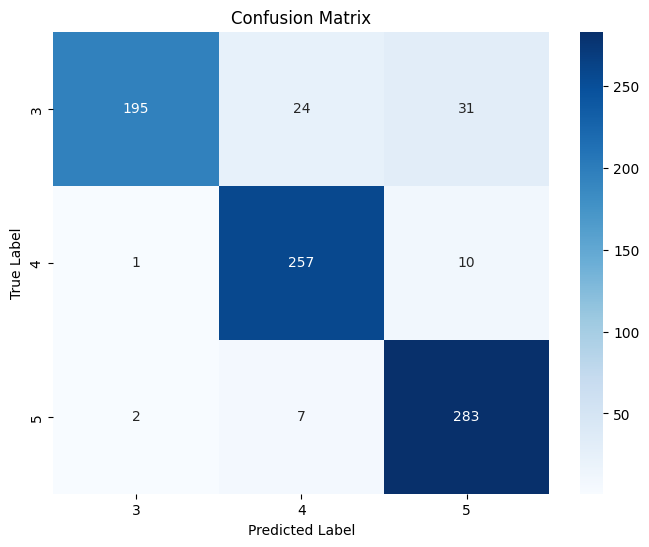

CNB Confusion Matrix


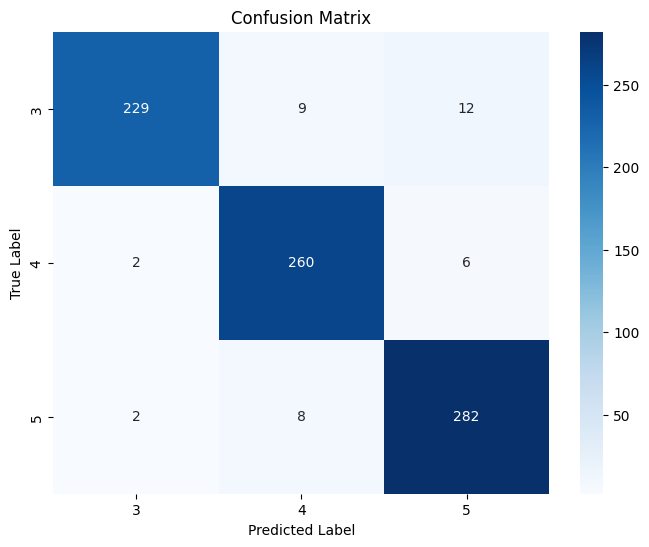

SVC Confusion Matrix


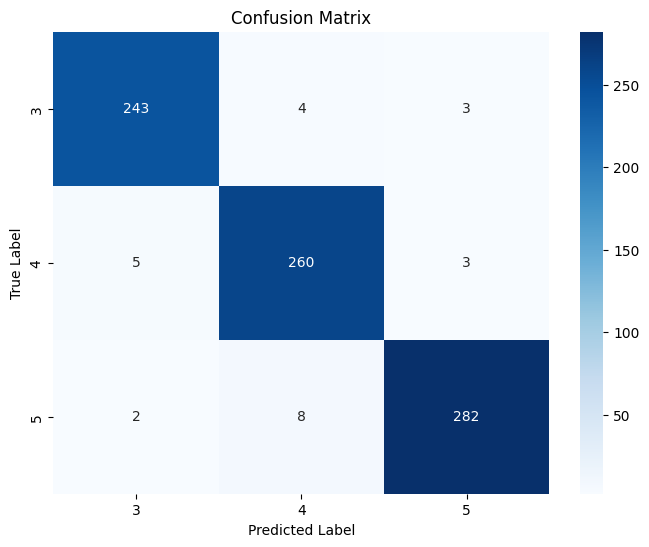

RF Confusion Matrix


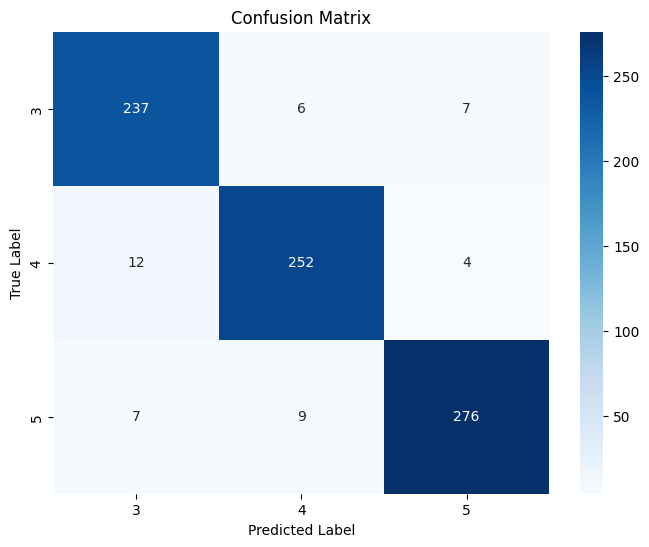

GB Confusion Matrix


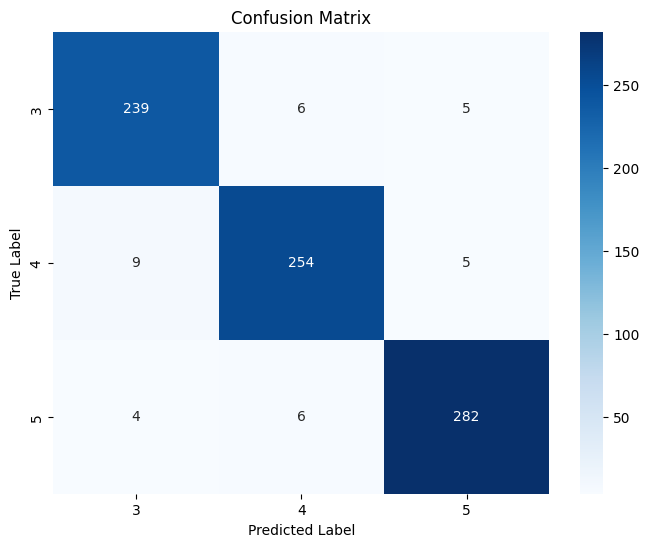

LR Confusion Matrix


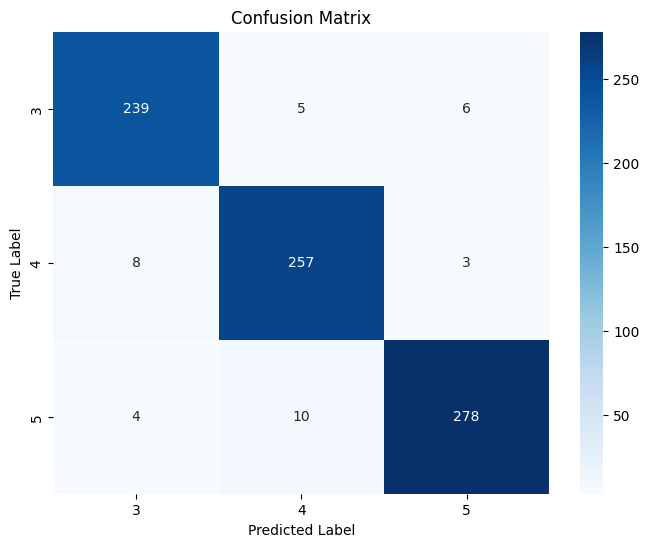

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Función para plotear la matriz de confusión
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Obtener y mostrar las matrices de confusión
cmMNB = confusion_matrix(y_test, predictMNB)
print("MNB Confusion Matrix")
plot_confusion_matrix(cmMNB, classes=y.unique())

cmCNB = confusion_matrix(y_test, predictCNB)
print("CNB Confusion Matrix")
plot_confusion_matrix(cmCNB, classes=y.unique())

cmSVC = confusion_matrix(y_test, predictSVC)
print("SVC Confusion Matrix")
plot_confusion_matrix(cmSVC, classes=y.unique())

cmRF = confusion_matrix(y_test, predictRF)
print("RF Confusion Matrix")
plot_confusion_matrix(cmRF, classes=y.unique())

cmGB = confusion_matrix(y_test, predictGB)
print("GB Confusion Matrix")
plot_confusion_matrix(cmGB, classes=y.unique())

cmLR = confusion_matrix(y_test, predictLR)
print("LR Confusion Matrix")
plot_confusion_matrix(cmLR, classes=y.unique())